In [1]:
import os
import cv2
import random
import pydicom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
INPUT_PATH = 'D:\\AI_Database\\TBI\\rsna-intracranial-hemorrhage-detection/'
os.listdir(INPUT_PATH)

['stage_2_sample_submission.csv',
 'stage_2_test',
 'stage_2_train',
 'stage_2_train.csv']

So Image IDs of form ID_SUBTYPE, which means we would have to make predictions for each subtype under a image ID. any --> indicates there is at least one subtype present telling us that patient has IH or not Label --> indicates probability of presence

In [3]:
train_df = pd.read_csv(INPUT_PATH+"stage_2_train.csv")
train_df.head(10)

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0
5,ID_12cadc6af_any,0
6,ID_38fd7baa0_epidural,0
7,ID_38fd7baa0_intraparenchymal,0
8,ID_38fd7baa0_intraventricular,0
9,ID_38fd7baa0_subarachnoid,0


In [192]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4516842 entries, 0 to 4516841
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   ID      object
 1   Label   int64 
dtypes: int64(1), object(1)
memory usage: 68.9+ MB


In [189]:
sample_sub = pd.read_csv(INPUT_PATH+"stage_2_sample_submission.csv")
sample_sub.head(10)

,ID,Label
0,ID_0fbf6a978_epidural,0.5
1,ID_0fbf6a978_intraparenchymal,0.5
2,ID_0fbf6a978_intraventricular,0.5
3,ID_0fbf6a978_subarachnoid,0.5
4,ID_0fbf6a978_subdural,0.5
5,ID_0fbf6a978_any,0.5
6,ID_d62ec3412_epidural,0.5
7,ID_d62ec3412_intraparenchymal,0.5
8,ID_d62ec3412_intraventricular,0.5
9,ID_d62ec3412_subarachnoid,0.5


In [185]:
print(train_df.ID.str.rsplit("_"))

0                  [ID, 12cadc6af, epidural]
1          [ID, 12cadc6af, intraparenchymal]
2          [ID, 12cadc6af, intraventricular]
3              [ID, 12cadc6af, subarachnoid]
4                  [ID, 12cadc6af, subdural]
                         ...                
4516837    [ID, 4a85a3a3f, intraparenchymal]
4516838    [ID, 4a85a3a3f, intraventricular]
4516839        [ID, 4a85a3a3f, subarachnoid]
4516840            [ID, 4a85a3a3f, subdural]
4516841                 [ID, 4a85a3a3f, any]
Name: ID, Length: 4516842, dtype: object


In [190]:
dat = train_df.copy()

In [191]:
dat = dat.ID.str.rsplit("_",n=1,expand=True)
dat.loc[:, "label"] = labels
dat.head()

,0,1,label
0,ID_12cadc6af,epidural,0
1,ID_12cadc6af,intraparenchymal,0
2,ID_12cadc6af,intraventricular,0
3,ID_12cadc6af,subarachnoid,0
4,ID_12cadc6af,subdural,0


In [140]:
dat = dat.rename({0 : "image",1 : "subtype"}, axis=1)
subtype_count = dat.groupby("subtype").label.value_counts().unstack()
subtype_count

label,0,1
subtype,,
any,644874,107933
epidural,749662,3145
intraparenchymal,716689,36118
intraventricular,726602,26205
subarachnoid,717132,35675
subdural,705641,47166


In [141]:
#calculating the % target distribution across each subtype
subtype_count_per =  subtype_count.loc[:,1]/dat.groupby("subtype").size() *100

multi_target_count = dat.groupby("image").label.sum()

In [142]:
#Helper function
def random_colors(num_colors : int):
    colors = []
    for i in range(num_colors):
        colors.append('#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors 

Text(0.5, 1.0, 'Imbalance in target distrubution')

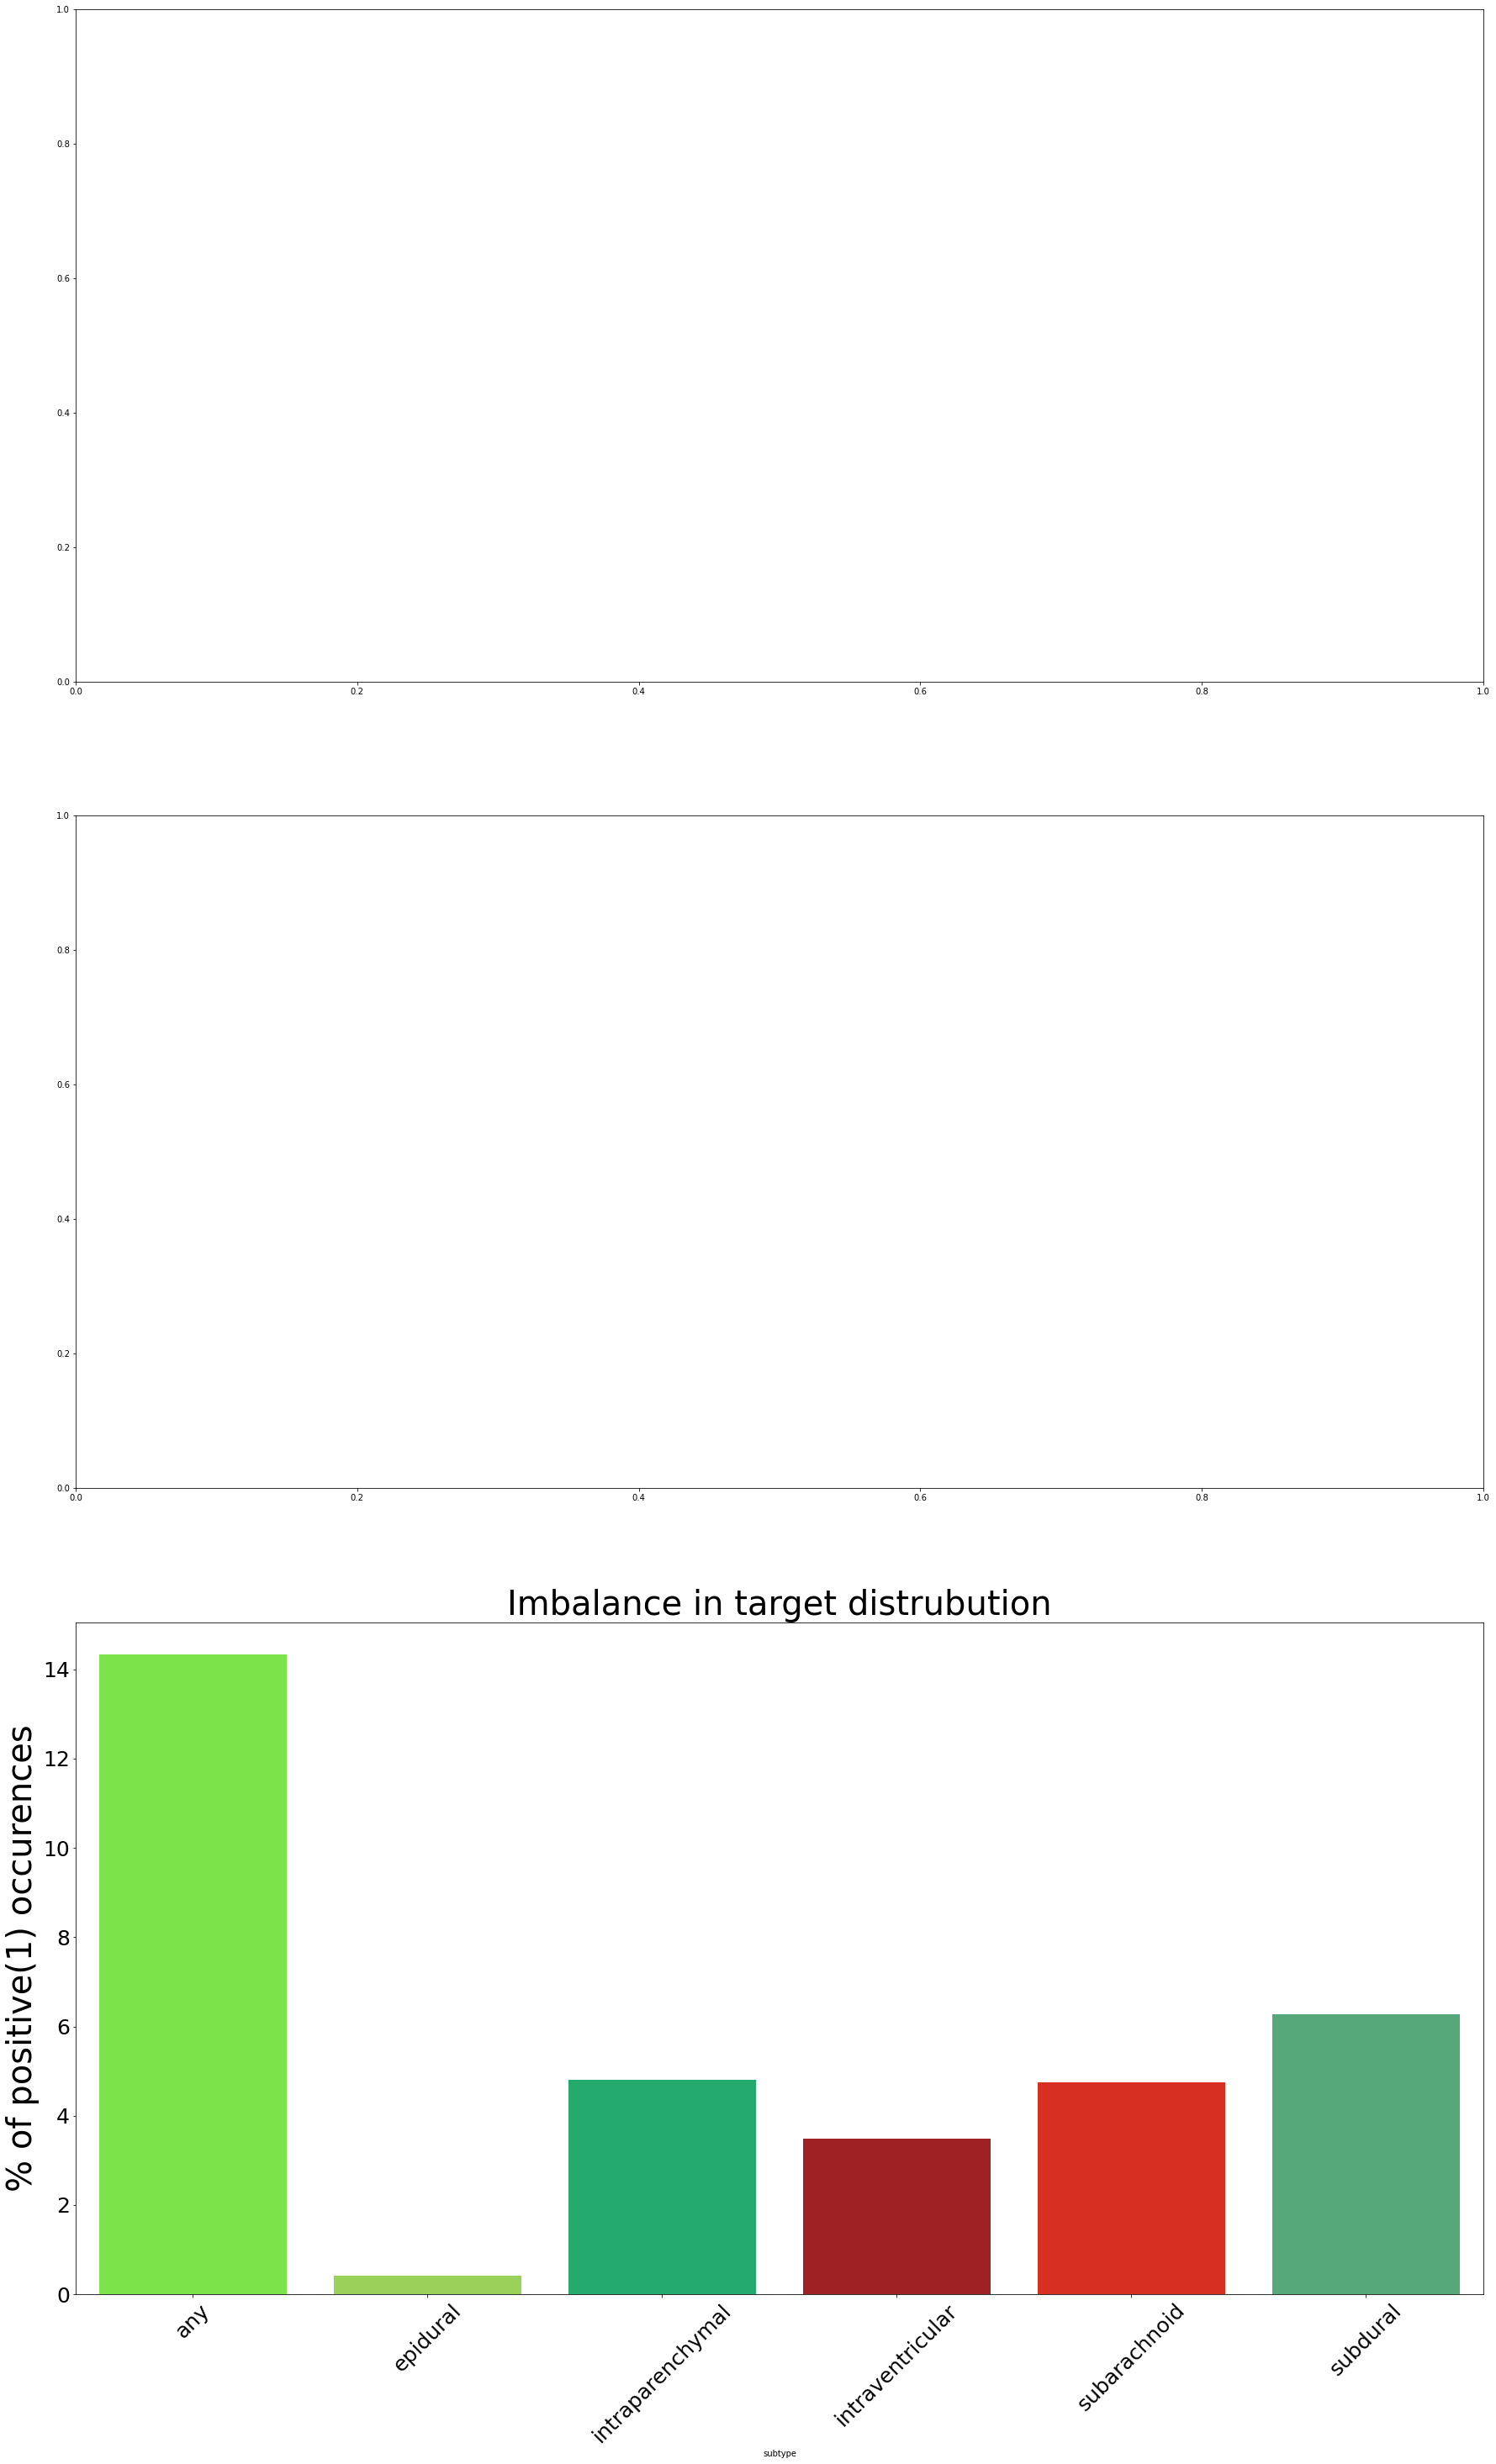

In [143]:
fig, ax = plt.subplots(3,1,figsize=(30,50))
sns.barplot(subtype_count_per.index, subtype_count_per.values, ax=ax[2], palette=random_colors(6))
plt.xticks(rotation=45)
ax[2].set_ylabel("% of positive(1) occurences",fontsize=40)
ax[2].tick_params(axis='x', labelsize=25 ) 
ax[2].tick_params(axis='y', labelsize=25 ) 
ax[2].set_title("Imbalance in target distrubution",fontsize=40)

In [144]:
train_files = os.listdir(INPUT_PATH+"stage_2_train")

In [145]:
train_files[:5]

['ID_000012eaf.dcm',
 'ID_000039fa0.dcm',
 'ID_00005679d.dcm',
 'ID_00008ce3c.dcm',
 'ID_0000950d7.dcm']

- Dicom is a format that has metadata, as well as Pixeldata attached to it. Below I extract some basic info with an image. You will know about the gender and age of the patient, as well as info how the image is sampled and generated.

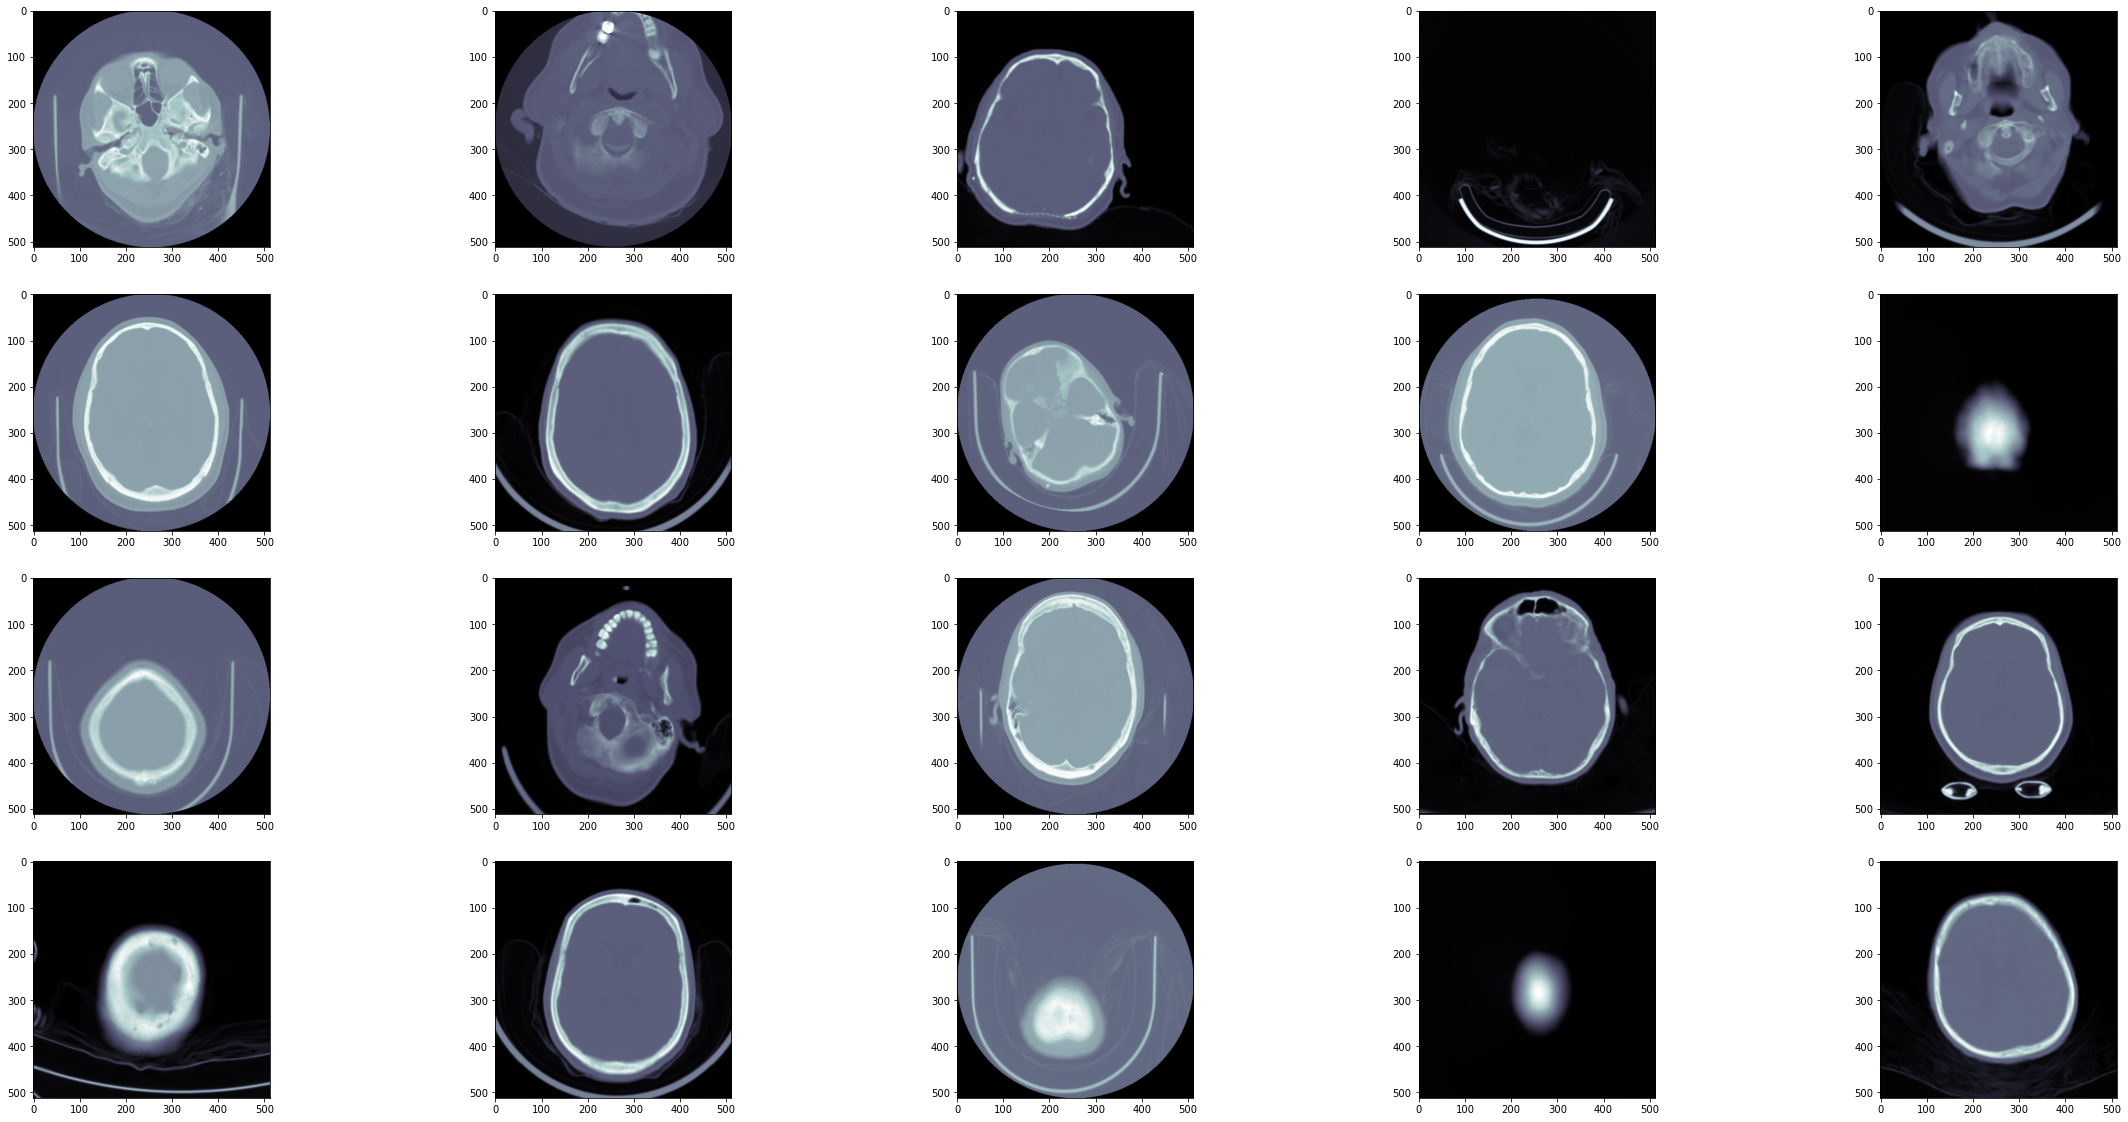

In [146]:
fig = plt.figure(figsize=(40,20))
column= 5; rows = 4
for i in range(1, column*rows +1):
    dcm = pydicom.dcmread(INPUT_PATH+"stage_2_train/"+train_files[i])
    fig.add_subplot(rows, column, i)
    plt.imshow(dcm.pixel_array, cmap=plt.cm.bone)
    fig.add_subplot

In [147]:
print(dcm)

Dataset.file_meta -------------------------------
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 10000000208461
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: 'RSNA Challenge 2019'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: ID_000270f8b
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_4942f4e0'
(0020, 000d) Study Instance UID                  UI: ID_7b6962cbb9
(0020, 000e) Series Instance UID                 UI: ID_597a2eb6cf
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: [-125, -88, 292.300049]
(0020, 0037) Image Orientation (Patient)         DS: [1, 0, 0, 0, 1, 0]
(0028, 0002) Samp

In [148]:
image = dcm.pixel_array
print(type(image)) #format in which pixel data is stored
print(image.dtype) #datatype of the pixel values
print(image.shape) #shape of image(wxh)

<class 'numpy.ndarray'>
uint16
(512, 512)


In [149]:
train_df[['ID', 'type']] = train_df['ID'].str.rsplit("_", n=1, expand=True)
train_df.drop_duplicates(['ID', 'type'], inplace=True)
train_df = train_df.pivot('ID', 'type', 'Label')
train_df.reset_index(inplace=True)
train_df.tail(20)

type,ID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
752783,ID_fffe2edb8,1,0,1,1,0,0
752784,ID_fffe38f8c,0,0,0,0,0,0
752785,ID_fffe408f0,0,0,0,0,0,0
752786,ID_fffe45a2a,0,0,0,0,0,0
752787,ID_fffe73397,0,0,0,0,0,0
752788,ID_fffe8db2a,0,0,0,0,0,0
752789,ID_fffecf238,0,0,0,0,0,0
752790,ID_ffff225b3,0,0,0,0,0,0
752791,ID_ffff3212e,0,0,0,0,0,0
752792,ID_ffff53123,0,0,0,0,0,0


- The training dataset is provided as set imageId and multiple labels, one for each of the subtypes of hemorrhage along with an addition lable for any(will be true of any of the subtype labels in true). So this is a multilable classification task.

## some of the original images

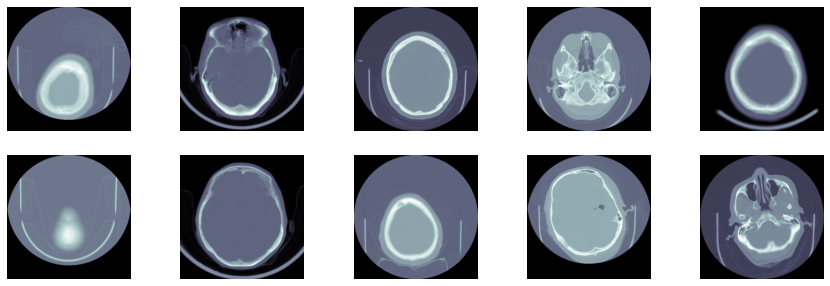

In [150]:
train_path = os.listdir(INPUT_PATH+"stage_2_train/")

def visualize(imgs, axes=None, rows=2, cols=5, **kwargs):
    if axes is None: _, axes = plt.subplots(rows, cols, **kwargs)
    for img, ax in zip(imgs, axes.flatten()):
        ax.imshow(img, cmap='bone')
        ax.axis("off")

sample_df = train_df.sample(10, random_state=8);
sample_df_fnames = [INPUT_PATH+"stage_2_train/" + f"{id_}.dcm" for id_ in sample_df['ID'].values];

dcms = [pydicom.dcmread(fname) for fname in sample_df_fnames];
arrs = [dcm.pixel_array for dcm in dcms];
visualize(arrs, figsize=(15, 5))

In [151]:
def segment_circle(windowed):
    original = windowed.copy().astype("uint8")
    mask = np.zeros(original.shape, dtype=np.uint8)
    gray = original
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=5)
    cnts = cv2.findContours(close, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)
        area = cv2.contourArea(c)
        if len(approx) > 4 and area > 10000 and area < 500000:
            ((x, y), r) = cv2.minEnclosingCircle(c)
            cv2.circle(mask, (int(x), int(y)), int(r), (255, 255, 255), -1)
            cv2.circle(original, (int(x), int(y)), int(r), (36, 255, 12), 0)
    x,y,w,h = cv2.boundingRect(mask)
    mask_ROI = mask[y:y+h, x:x+w]
    image_ROI = original[y:y+h, x:x+w]
    result = cv2.bitwise_and(image_ROI, image_ROI, mask=mask_ROI)
    return result, (x, y, w, h)

def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(img, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def preprocess_and_segment(path, norm='min_max', make_correct=True):    
    dcm = pydicom.dcmread(path)
    if make_correct and (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)

    sample = dcm.pixel_array.astype("float32") * dcm.RescaleSlope + dcm.RescaleIntercept
    
    brain_window = window_image(sample, 40, 80)
    dural_window = window_image(sample, 80, 200)
    bone_window = window_image(sample, 600, 2800)
    
    brain_window, (x,y,w,h) = segment_circle(brain_window)
    if brain_window is None:
        return np.zeros((512, 512, 3))
    dural_window = dural_window[y:y+h, x:x+w]
    bone_window = bone_window[y:y+h, x:x+w]
    
    # Just some normalization. You can ignore this
    if norm == "min_max":
        brain_window = (brain_window - (0.)) / 80.
        dural_window = (dural_window - (-20.)) / 200.
        bone_window = (bone_window - (-1200.)) / 2800.
        img_3ch = np.dstack([brain_window, dural_window, bone_window]).astype("float32")
    elif norm == "hu":
        img_3ch = np.dstack([brain_window, dural_window, bone_window]).astype("float32") / 4096.
    elif norm == 'none':
        img_3ch = np.dstack([brain_window, dural_window, bone_window]).astype("float32")
    
    return img_3ch

## Raw Images

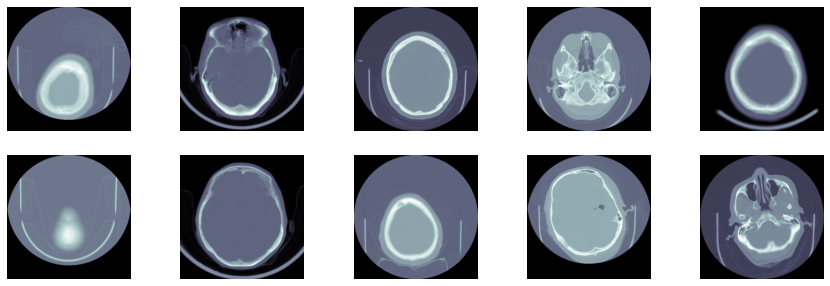

In [152]:
sample_df = train_df.sample(10, random_state=8)
sample_df_fnames = [INPUT_PATH+"stage_2_train/" + f"{id_}.dcm" for id_ in sample_df['ID'].values]

dcms = [pydicom.dcmread(fname) for fname in sample_df_fnames]
arrs = [dcm.pixel_array for dcm in dcms]
visualize(arrs, figsize=(15, 5))

## Preprocessing the images

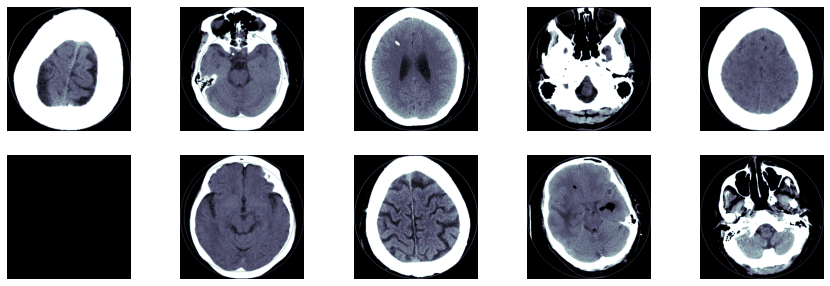

In [153]:
proccessed = [preprocess_and_segment(fname, norm="min_max") for fname in sample_df_fnames]
visualize([img[..., 0] for img in proccessed], figsize=(15, 5))

In [154]:
sub = pd.read_csv(INPUT_PATH+"stage_2_sample_submission.csv")
sub.head(10)

,ID,Label
0,ID_0fbf6a978_epidural,0.5
1,ID_0fbf6a978_intraparenchymal,0.5
2,ID_0fbf6a978_intraventricular,0.5
3,ID_0fbf6a978_subarachnoid,0.5
4,ID_0fbf6a978_subdural,0.5
5,ID_0fbf6a978_any,0.5
6,ID_d62ec3412_epidural,0.5
7,ID_d62ec3412_intraparenchymal,0.5
8,ID_d62ec3412_intraventricular,0.5
9,ID_d62ec3412_subarachnoid,0.5


In [111]:
! pip3 install opencv-python --user

In [ ]:
sub = pd.read_csv(INPUT_PATH+"stage_2_sample_submission.csv")
sub.head(10)

In [ ]:
! pip3 install tensorflow

In [5]:
import cv2

## Get small subset of original dataset

In [8]:
import os
import random
from shutil import copy, make_archive

In [9]:
os.makedirs('./dataset', exist_ok=True)